# Single Robot

The code for this example is implemented [single_robot](https://github.com/jeguzzi/enki_env/tree/main/enki_env/examples/single_robot). Let us import it.

In [1]:
from enki_env.examples import single_robot

## Environment

The environment contains a single Thymio robot and a long wall. The initial position of the robot is fixed while the orientation is sampled uniformly. 
The robot goal is to rotate so to face the wall perpendicularly in the least amount of time.

To create the environment via script, run:
```console
python -m enki_env.examples.single_robot.environment
```

In [2]:
env = single_robot.make_env(render_mode="human")
env.reset();

RFBOutputContext()

EnkiRemoteFrameBuffer()
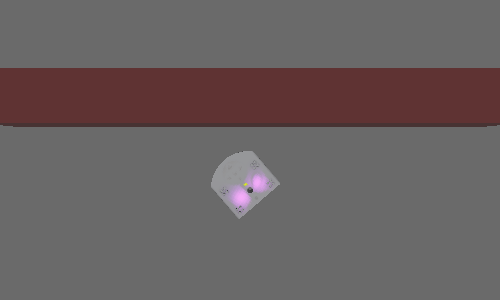

In [3]:
env.unwrapped.display_in_notebook()

The view above is interactive. Try to zoom in and out (trackpad/mouse wheel).  Try also to select (mouse click) and move the robot (dragging while mouse pressed).

The robot, in this configuration

In [4]:
env.unwrapped.config.action

ThymioAction(max_speed=16.6, max_acceleration=1, fix_orientation=False, fix_position=True, acceleration=False, dtype=<class 'numpy.float64'>, prox_comm=False, max_proximity_comm_payload=1)

is constrained to stay in place (``fix_position=True``).
The action space

In [5]:
env.action_space

Box(-1.0, 1.0, (1,), float64)

contains a single value that is applied as negative speed for the left wheel and positive speed for the righ wheel.

Observations are configured

In [6]:
env.unwrapped.config.action

ThymioAction(max_speed=16.6, max_acceleration=1, fix_orientation=False, fix_position=True, acceleration=False, dtype=<class 'numpy.float64'>, prox_comm=False, max_proximity_comm_payload=1)

so that the observation space

In [7]:
env.observation_space

Dict('prox/value': Box(0.0, 1.0, (7,), float64))

contain just the value of measured by the proximity sensors, normalized between 0 and 1.

The reward

In [8]:
import inspect

print(inspect.getsource(env.unwrapped.config.reward))

def reward(robot: pyenki.DifferentialWheeled, world: pyenki.World) -> float:
    return -1 - abs(robot.angle)



penalizes the robot that is not facing the wall (`angle=0`).
The task terminate when the robot faces the wall and speed is now.

In [9]:
print(inspect.getsource(env.unwrapped.config.terminations[0]))

def in_front_of_wall(robot: pyenki.DifferentialWheeled,
                     world: pyenki.World) -> bool | None:
    if abs(robot.angle) < 0.05 and abs(
            robot.left_wheel_encoder_speed) < 1 and abs(
                robot.right_wheel_encoder_speed) < 1:
        # Success
        return True
    return None



Let us try to apply a random actions for few steps and record the reward

In [10]:
rollout = env.unwrapped.rollout(max_steps=10)

In [11]:
rollout.reward

array([[-1.32870805],
       [-1.19023335],
       [-1.26187667],
       [-1.0609842 ],
       [-1.33067046],
       [-1.45467138],
       [-1.73258829],
       [-1.7089751 ],
       [-1.61573099],
       [-1.65805245]])

## Baseline

We have hand-coded a simple policy to achieve the task.

To evaluate the baseline via script, run:
```console
python -m enki_env.examples.single_robot.baseline
```

In [12]:
print(inspect.getsource(single_robot.Baseline.predict))

    def predict(self,
                observation: Observation,
                state: State | None = None,
                episode_start: EpisodeStart | None = None,
                deterministic: bool = False) -> tuple[Action, State | None]:
        prox = observation['prox/value']
        if any(prox[:5] > 0):
            w = 0.25 * (prox[0] + 2 * prox[1] - 2 * prox[3] - prox[4])
        else:
            w = 1
        return np.clip([w], -1, 1), None



EnkiRemoteFrameBuffer()
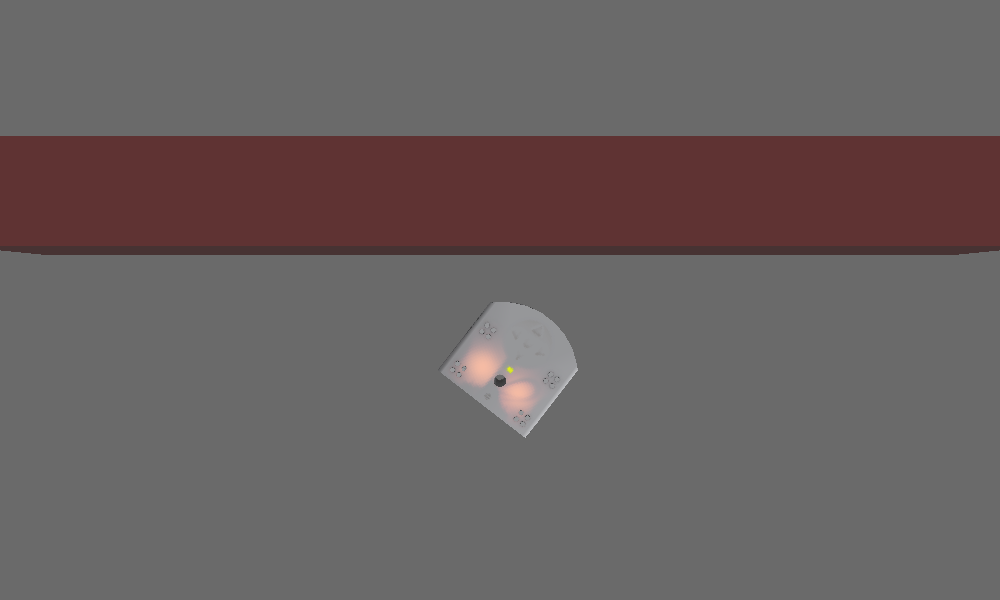

In [13]:
env.unwrapped.display_in_notebook()

Try changing the seed and redo the rollout!

If we want to evaluate quatitatively better to use a environemtn without (real-time) rendei 

Let us evaluate it over some episode (we disable real-time rendering to speed it up)

In [15]:
import numpy as np

eval_env = single_robot.make_env(render_mode=None)

rollouts = [eval_env.unwrapped.rollout(seed=i, policy=single_robot.Baseline()) for i in range(100)]
rewards = np.array([rollout.episode_reward for rollout in rollouts])
steps =  np.array([rollout.episode_length for rollout in rollouts])
print(f"Mean reward: {rewards.mean(): .1f}, mean steps: {steps.mean(): .1f}")

Mean reward: -9.1, mean steps:  6.8


## Reinforcement learning

Let us now train and evaluate a RL policy for the same task.

To perform this via script, run:
```console
python -m enki_env.examples.single_robot.rl


In [16]:
policy = single_robot.get_policy()

Let's redo the same evaluation but with the trained policy

In [17]:
rollouts = [eval_env.unwrapped.rollout(seed=i, policy=policy) for i in range(100)]
rewards = np.array([rollout.episode_reward for rollout in rollouts])
steps =  np.array([rollout.episode_length for rollout in rollouts])
print(f"Mean reward: {rewards.mean(): .1f}, mean steps: {steps.mean(): .1f}")

Mean reward: -20.8, mean steps:  16.1


## Video

The examples includes a script to generate a video where, for the same initial states, first we play out the episode using the baseline and then using the RL policy.  The Thymio changes colors between yellow (baseline) and cyan (policy)

```console
python -m enki_env.examples.single_robot.video

In [18]:
video = single_robot.make_video()
video.display_in_notebook(fps=30, width=640)